# Functional Principal Component Analysis

In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from fpca import FPCA

In [47]:
%matplotlib inline

mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['xtick.labelsize']= 14
mpl.rcParams['ytick.labelsize']= 14

## Toy problem

Our simple toy problem is using artificial data which is a linear combination of 3 sin functions of different frequencies. Each sin function represents a "functional process" that makes up the data.

Sin functions $sin(mx)$ and $sin(nx)$ are orthogonal to each other if $m \ne n$ in the domain $-\pi$ to $+\pi$. Therefore, these represent orthogonal basis functions.

In [48]:
# Time domain
t = np.linspace(-np.pi, np.pi, 200)
# Frequencies
w1 = 3
w2 = 5
w3 = 14

# Noisy Data
data = np.zeros((4, 200))

data[0, :] = 5*np.sin(w1*t) + 2*np.sin(w2*t) + 20*np.sin(w3*t)
data[1, :] = 12*np.sin(w1*t) + 5*np.sin(w2*t) + 7*np.sin(w3*t)
data[2, :] = 8*np.sin(w1*t) + 3*np.sin(w2*t) + np.sin(w3*t)
data[3, :] = np.sin(w1*t) + 18*np.sin(w2*t)

# Add white noise
for i in range(4):
    data[i, :] = data[i, :] + np.random.normal(0, 2, 200)

# Basis functions
phi = np.zeros((6, 200))

# First three Phi(t) are orthogonal
phi[0, :] = np.sin(w1*t)
phi[1, :] = np.sin(w2*t)
phi[2, :] = np.sin(w3*t)
phi[3, :] = np.sin(w1*t) + np.sin(w2*t)
phi[4, :] = np.sin(w2*t) + np.sin(w3*t)
phi[5, :] = np.sin(w1*t) + np.sin(w3*t)

# First three Phi(t) are now orthonormal
phi[0, :] /= np.linalg.norm(phi[0, :])
phi[1, :] /= np.linalg.norm(phi[1, :])
phi[2, :] /= np.linalg.norm(phi[2, :])

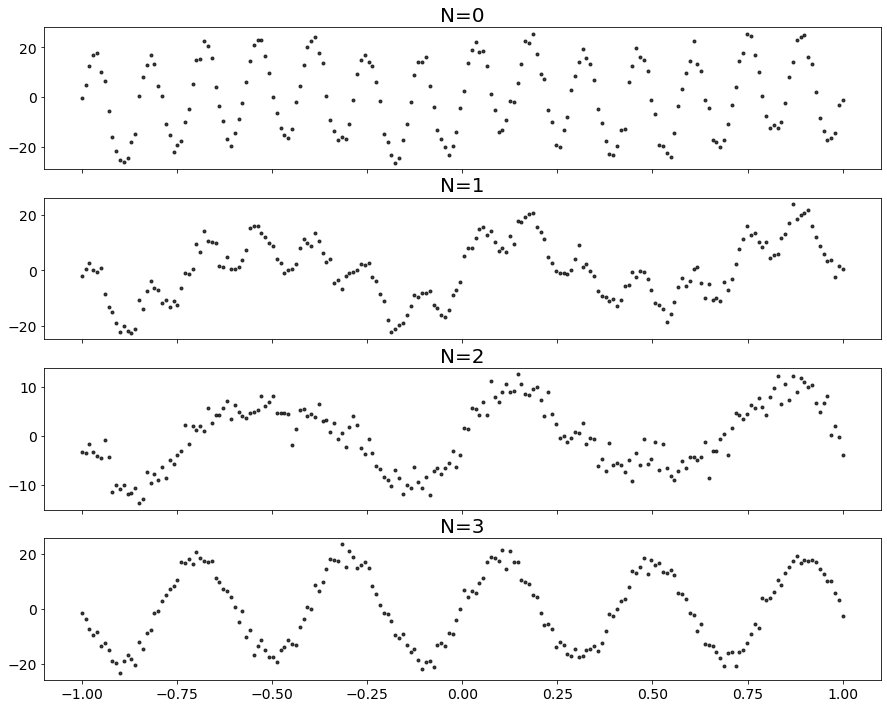

In [49]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(15, 12))

for i in range(4):
    ax[i].scatter(t/np.pi, data[i], marker='.', color='black', alpha=0.75)
    ax[i].set_title('N={}'.format(i), fontsize=20)

Text(0.5, 1.0, '$\\Phi$ Orthonormal basis')

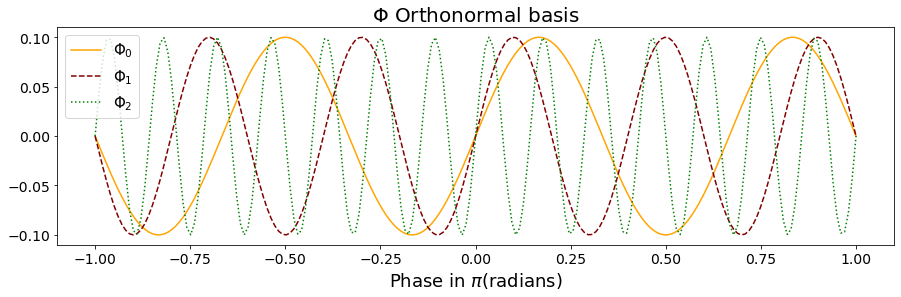

In [50]:
plt.figure(figsize=(15, 4))
plt.plot(t/np.pi, phi[0, :], label=r'$\Phi_0$', color='orange')
plt.plot(t/np.pi, phi[1, :], label=r'$\Phi_1$', color='maroon', ls='--')
plt.plot(t/np.pi, phi[2, :], label=r'$\Phi_2$', color='green', ls='dotted')
plt.legend(fontsize=15)
plt.xlabel(r'Phase in $\pi$(radians)')
plt.title(r'$\Phi$ Orthonormal basis', fontsize=20)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 843.71it/s]


Text(0.5, 1.0, '$\\Psi$ Eigenfunctions')

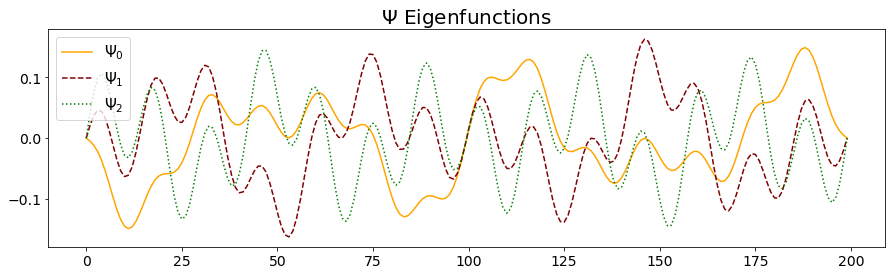

In [51]:
# FPCA using first 3 Phis, i.e. the 3 orthonomal sin functions
fpca_test_3 = FPCA(data, 3, phi=phi)
fpca_test_3.alpha_regression()
fpca_test_3.solve_eigenproblem()

plt.figure(figsize=(15, 4))
plt.plot(fpca_test_3.psi_cap_t[:, 0], color='orange', label=r'$\Psi_0$')
plt.plot(fpca_test_3.psi_cap_t[:, 1], color='maroon', label=r'$\Psi_1$', ls='--')
plt.plot(fpca_test_3.psi_cap_t[:, 2], color='green', label=r'$\Psi_2$', ls='dotted')
plt.legend(fontsize=15)
plt.title(r'$\Psi$ Eigenfunctions', fontsize=20)

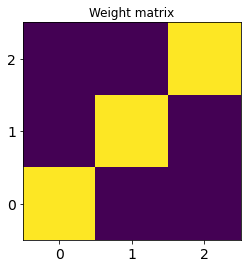

In [52]:
# Weight matrix
W = np.dot(fpca_test_3.phi_t, fpca_test_3.phi_t.T)

# Weight matrix is identity matrix since we have orthonormal basis
plt.imshow(W, cmap='viridis', interpolation=None, origin='lower')
plt.title("Weight matrix", fontsize=12)
plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.show()

Text(0.5, 0, 'Phase in $\\pi$(radians)')

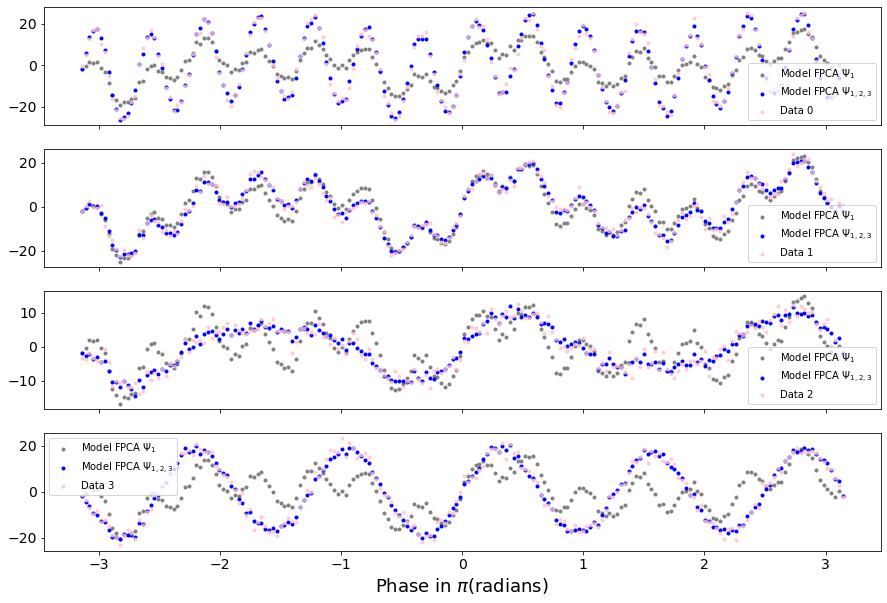

In [53]:
x_j = np.dot(fpca_test_3.x_centered, fpca_test_3.psi_cap_t)

fpca_1 = np.dot(x_j[:, 0:1], fpca_test_3.psi_cap_t[:, 0:1].T)
fpca_all = np.dot(x_j, fpca_test_3.psi_cap_t.T)

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(15, 10))

for i in range(4):
    ax[i].scatter(t, fpca_1[i] + fpca_test_3.sample_mu, color='grey', marker='.', label=r'Model FPCA $\Psi_1$')
    ax[i].scatter(t, fpca_all[i] + fpca_test_3.sample_mu, color='blue', marker='.', label=r'Model FPCA $\Psi_{1,2,3}$')
    ax[i].scatter(t, data[i], label='Data {}'.format(i), color='pink', marker='.', alpha=0.75)
    ax[i].legend()

plt.xlabel(r'Phase in $\pi$(radians)')

In [56]:
# Compare our technique with the use of PCA on regressed values
alpha_pca = PCA(n_components=3)
alpha_pca.fit(fpca_test_3.regressed_alpha)

# Eigenfunctions using alpha PCA
psi_t = np.dot(fpca_test_3.phi_t.T, alpha_pca.components_)

Text(0.5, 0, 'Phase in $\\pi$(radians)')

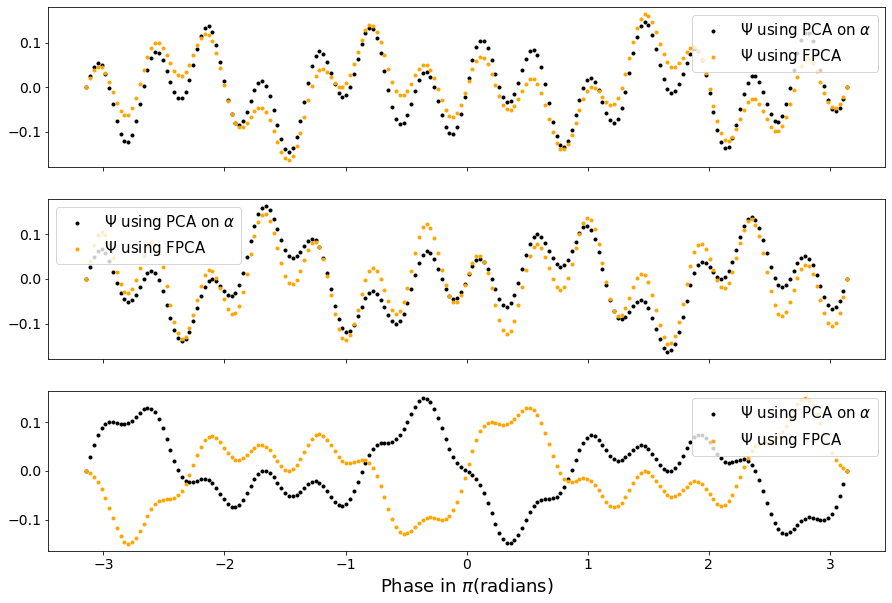

In [57]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 10))

for i in range(3):
    ax[i].scatter(t, psi_t[:, i], color='black', marker='.', label=r'$\Psi$ using PCA on $\alpha$')
    ax[i].scatter(t, fpca_test_3.psi_cap_t[:, (i+1)%3], marker='.', color='orange', label=r'$\Psi$ using FPCA')
    ax[i].legend(fontsize=15)

plt.xlabel(r'Phase in $\pi$(radians)')

For orthonormal basis functions, FPCA reduces to doing PCA on $\alpha$. This is because the weight matrix $W$ is the identity matrix for orthonormal basis functions. This test shows that doing FPCA on $\alpha$ is equivalent to solving the full eigenfunction. Thus, it verifies that FPCA is working properly.